# Metody Programowania Równoległego
*Temat: Message Passing Interface*

Wykonał: **Paweł Kruczkiewicz**

In [35]:
import pandas as pd
import matplotlib.pyplot as plt

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

## Kod Programu
Do wykonania pomiarów posłużono się poniżej przedstawionym programem napisanym w języku C:
    
```C
#include <stdio.h>
#include <stdlib.h>
#include <time.h>
#include <mpi.h>

#define N 1001
#define DEFAULT_TAG 0
#define TEST_CASES_NUM 6
#define CSV_NAME "results/normal_1_node.csv"

void init_mpi(int* argc, char** argv[], int* rank, int* size){
   MPI_Init (argc, argv);  /* starts MPI */
  MPI_Comm_rank (MPI_COMM_WORLD, rank);  /* get current process id */
  MPI_Comm_size (MPI_COMM_WORLD, size);  /* get number of processes */
}

void my_MPI_send(int* number_buf, int number_amount, int receiver) {
  # ifdef BUFFERED
        int buffer_attached_size = MPI_BSEND_OVERHEAD +  number_amount*sizeof(int);
        char* buffer_attached = (char*) malloc(buffer_attached_size);
        MPI_Buffer_attach(buffer_attached, buffer_attached_size);

        MPI_Bsend(number_buf, number_amount, MPI_INT, receiver, DEFAULT_TAG, MPI_COMM_WORLD);
        
        MPI_Buffer_detach(&buffer_attached, &buffer_attached_size);
        free(buffer_attached); 
  # else
      MPI_Send(number_buf, number_amount, MPI_INT, receiver, DEFAULT_TAG, MPI_COMM_WORLD);
  # endif /* BUFFERED */

}


void my_MPI_receive(int* number_buf, int number_amount, int sender){
  MPI_Recv(number_buf, number_amount, MPI_INT, sender, DEFAULT_TAG, MPI_COMM_WORLD, MPI_STATUS_IGNORE);
}

void MPI_one_ping_pong(int rank, int* number_buf, int number_amount) {
  if (rank == 0) {
  	my_MPI_send(number_buf, number_amount, 1);
        my_MPI_receive(number_buf, number_amount, 1);
  } else if (rank == 1) {
        my_MPI_receive(number_buf, number_amount, 0); 
  	my_MPI_send(number_buf, number_amount, 0);
  }
}

int* init_buf(int n){
  int* buf = (int*) malloc(sizeof(int) * n);
  int i;
  for (i=0; i < n; i++){
     buf[i] = -1;
  }
  return buf;
}

double measure_ping_pong_time(int rank, int number_amount) {
  
  int i;
  double t1, t2;
  int* number_buf = init_buf(number_amount);

  MPI_Barrier(MPI_COMM_WORLD);
  t1 = MPI_Wtime();
  for (i = 0; i < N; i++){
     MPI_one_ping_pong(rank, number_buf, number_amount);    
  } 
  t2 = MPI_Wtime();

  free(number_buf);
  return (t2 - t1)/((double) N);
}

double compute_thrtp(double time_in_sec, int number_amount) {
  int buff_size = sizeof(int)*number_amount;
  return (double) (8*buff_size)/(1000000.0*time_in_sec);
}

void export_to_csv(int* buff_size, double* throughtputs) {
  printf("Message_size, Throughtput\n");
  
  int i;
  for (i = 0; i < TEST_CASES_NUM; i++) {
  	printf( "%d, %f\n", buff_size[i], throughtputs[i]);
  }
}

int main (int argc, char * argv[])
{
  int rank, size;
  init_mpi(&argc, &argv, &rank, &size);
 
  const int number_amounts[TEST_CASES_NUM] = {100, 1000, 10000, 100000,  1000000, 10000000};
  double* thrtps = (double*) malloc(sizeof(double)*TEST_CASES_NUM);
  int* buff_size = (int*) malloc(sizeof(int)*TEST_CASES_NUM);
  int i;  
  for (i = 0; i < TEST_CASES_NUM; i++) {
  	double snd_rcv_time_sec = measure_ping_pong_time(rank, number_amounts[i]);
  	buff_size[i] = sizeof(int)*number_amounts[i];
        thrtps[i] = compute_thrtp(snd_rcv_time_sec, number_amounts[i]); 
  } 
  double delay = 1000.0 * measure_ping_pong_time(rank, 1);  

  if (rank == 0) {
  	export_to_csv(buff_size, thrtps);
        printf("Delay: %f[ms]\n", delay);
  	
  }
  free(thrtps);
  free(buff_size);

  MPI_Finalize();

  return 0;
}

```

Był on kompilowany bez i z flagą `-DBUFFERED` w celu zbadania odpowiednio komunikacji niebuforowanej i buforowanej. 

Wyniki pobrano zarówno dla komunikacji na 1 nodzie, jak i pomiędzy 2 node'ami (dla obu typów komunikacji). Komunikacja na 1 nodzie odbyła się po ustawieniu `:2` przy nodzie nr 3 w pliku `allnodes`, a komunikacja między 2 odbyła się przy ustawieniu  `:1` przy nodach nr 9 i 10.

## Dane pomiarowe

W wyniku eksperymentu uzyskano 5 plików CSV. 4 z nich odnosiły się do przepustowości, 1 do opóźnienia. 
Dane pozyskano w czasie, w którym na klastrze nie znajdowało się wielu użytkowników, co sprawdzono za pomocą komendy `who`.

### Przepustowość od wielości danych

Czas przesyłu danych liczony był jako czas potrzebny na przesłanie `x` B danych w dwie strony. Seria wielkości danych rosła geometrycznie: każda kolejna wartość jest większa 10 razy. Każdy pomiar powtórzono 1001 razy. Przedstawione niżej dane sa wartością oczekiwaną.

Przepustowość została zapisana w Mbit/s, wielkość danych w B. Są to 4 pliki: 
  1. komunikacja niebuforowana - 1 node


In [9]:
normal_1_node = pd.read_csv("results/normal_1_node.csv")
normal_1_node

,Message_size,Throughtput
0,400,20.121754
1,4000,104.291489
2,40000,225.392701
3,400000,814.356677
4,4000000,1283.516045
5,40000000,1652.449831


2. komunikacja niebuforowana - 2 nody

In [62]:
normal_2_nodes = pd.read_csv("results/normal_2_nodes.csv")
normal_2_nodes

,Message_size,Throughtput
0,400,35.568814
1,4000,189.157758
2,40000,1345.707578
3,400000,1404.841344
4,4000000,1226.464586
5,40000000,1261.470569


3. komunikacja buforowana - 1 node

In [12]:
buf_1_node = pd.read_csv("results/buffered_1_node.csv")
buf_1_node

,Message_size,Throughtput
0,400,36.388835
1,4000,215.318647
2,40000,1320.634187
3,400000,564.011719
4,4000000,1018.657553
5,40000000,1117.138113


4. komunikacja buforowana - 2 nody

In [13]:
buf_2_nodes = pd.read_csv("results/buffered_2_nodes.csv")
buf_2_nodes

,Message_size,Throughtput
0,400,37.782293
1,4000,232.925589
2,40000,1510.648549
3,400000,816.289598
4,4000000,1072.329623
5,40000000,946.367913


### Opóźnienie

Odczytano 4 wielkości opóźnienia dla wszystkich 4 konfiguracji eksperymentu. Została ona obliczona jako długość przesyłu w obie strony komunikatu o wielkości 1 B. Wartość opóźnienia zapisano w ms.

In [19]:
delays = pd.read_csv("results/delays.csv")
delays

,Type,Number_of_nodes,Delay
0,normal,1,0.066799
1,normal,2,0.147370
2,buffered,1,0.066297
3,buffered,2,0.076020


## Wykresy
Wszystkie wykresy posiadają skalę logarytmiczną na osi x, ponieważ dane są tam 

In [78]:
def plot_log_line(x, y1, y2, title, x_label, y_label, y1_label, y2_label):
    plt.figure(figsize=(10, 7), dpi=80)
    
    plt.plot(x, y1, label=y1_label)
    plt.plot(x, y2, label=y2_label)
    plt.xscale("log")
    
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    
    plt.xticks(ticks=x, labels=x)
    
    plt.legend()
    plt.show()

### Porównanie przepustowości dla różnych typów komunikacji na 1 nodzie.

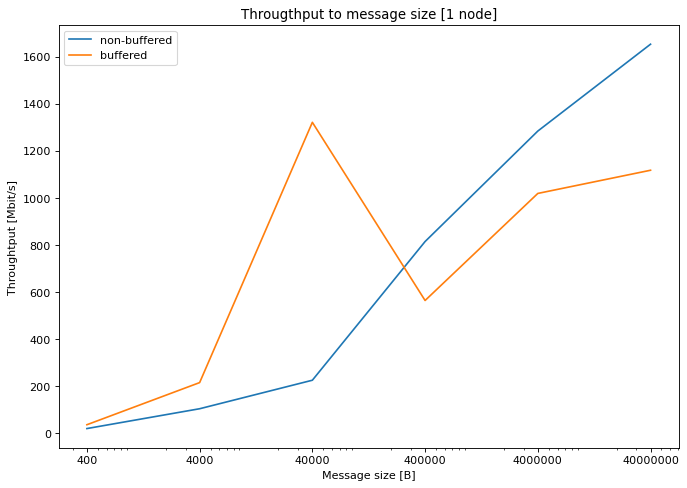

In [79]:
x = normal_1_node["Message_size"]
y1 = normal_1_node[" Throughtput"]
y2 = buf_1_node[" Throughtput"]
plot_log_line(x, y1, y2,
              title="Througthput to message size [1 node]",
              x_label="Message size [B]",
              y_label="Throughtput [Mbit/s]",
              y1_label="non-buffered", y2_label="buffered")


Pzepustowość dla komunikacji niebuforowanej stale rośnie. Jest to spowodowane ciągłym zmniejszaniem narzutu związanego z samym przesyłem danych w stosunku do całej wiadomości (procent wiadomości poświęcony na metadane w funkcji wielkości pakietu dąży do 0). Nie udało się jednak osiągnąć momentu "nasycenia". Dalsze testy były trudne do przeprowadzenia ze względu na długość czasu przesyłu.

Buforowanie nie podlega opisanej wyżej zasadzie, ponieważ narzut jest różny w zależności od wielkości komunikatu. Przepustowość buforowana jest większa dla małych i średnich wielkości pakietów (do 40 KB włącznie), jednak zdecydowanie mniejsza dla dużych pakietów. Jest to spowodowane tym, że dla dużych komunikatów wielkość pakietu "sama w sobie" stanowi bufor i dodatkowy narzut komunikacji buforowanej zwalnia przesył danych.

### Porównanie przepustowości dla różnych typów komunikacji na 2 nodach.

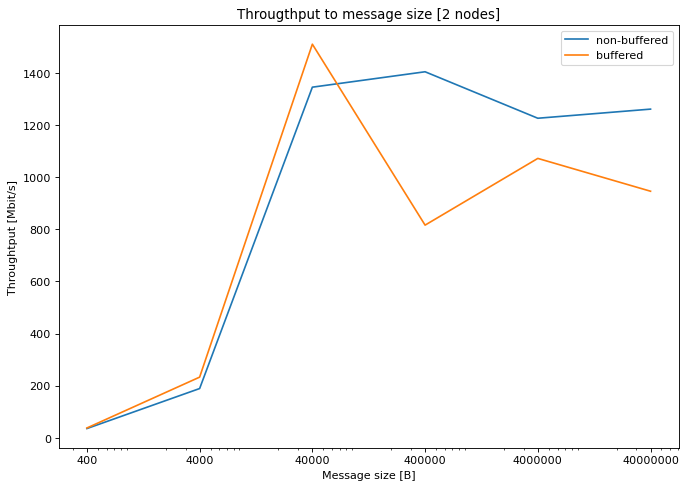

In [80]:
x = normal_2_nodes["Message_size"]
y1 = normal_2_nodes[" Throughtput"]
y2 = buf_2_nodes[" Throughtput"]
plot_log_line(x, y1, y2,
              title="Througthput to message size [2 nodes]",
              x_label="Message size [B]",
              y_label="Throughtput [Mbit/s]",
              y1_label="non-buffered", y2_label="buffered")

Wykres przepustowości do wielkości wiadomości dla 2 węzłów jest nieco podobny jak ten dla 1 węzła, jednak można zauważyć w nim drobne różnice. 

Po pierwsze - dla komunikacji niebuforowanej osiągnięto "nasycenie" równe ok. 1400 Mbit/s, co możemy traktować jako szczytową przepustowoś dla tego rodzaju komunikacji.

Po drugie - różnica przepustowości dla komunikacji buforowanej nie jest tak duża jak dla komunikacji niebuforowanej. Pozwala to stwierdzić, że komunikacja buforowana jest bardziej istotna w środowiskach gdzie komunikacja między procesami jest mniejsza i bufor potrzebny jest jako równoważnik dla różnicach w szybkości przesyłu a przetwarzania danych.

### Opóźnienie

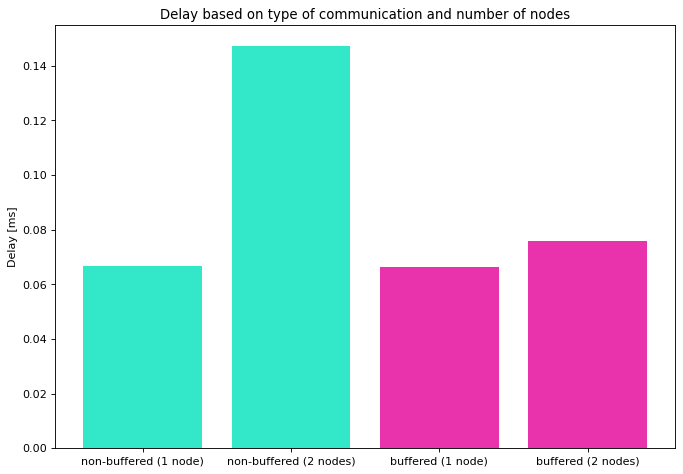

In [73]:
labels = ["non-buffered (1 node)", "non-buffered (2 nodes)", "buffered (1 node)", "buffered (2 nodes)"]
y = delays[" Delay"]
colors = ["#33e8c9", "#33e8c9", "#e833ad", "#e833ad"]
plt.figure(figsize=(10, 7), dpi=80)
plt.bar(labels, y, color=colors)
plt.title("Delay based on type of communication and number of nodes")
plt.ylabel("Delay [ms]")
plt.show()

Powyższy wykres pokazuje, że buforowanie jest szczególnie korzystne dla komunikacji między dwoma węzłami. Wartość opóźnienia nie zmienia się znacząco dla komunikacji buforowanej, czego nie można powiedzieć o komunikacji niebuforowanej, gdzie wartość ta jest niemal dwa razy wyższa dla komunikacji międzywęzłowej w porównaniu z komunicją w jednym węźle.

Jest to spowodowane tym, że procesor w komunikacji buforowanej ???